# Description of the input data 

In this Notebook, we describe the mandatory and optionnal input data.

## Mandatory data organization in folder

You must provide input data as follows : 

```
path2wd/<name>   
|
|-- ffid<idfeu>
    |
    |-- rs_data
    |   |-- ffid<idfeu>_*_YYYY-MM-DD.csv
    |   |-- ...
    |   |-- rs_metadata.csv
    |   |-- ffid<idfeu>_satellite_viewing_angles.tif (optionnal)
    |
    |-- geo_data
    |   |-- ffid<idfeu>_gridpoints.shp
    |   |-- ffid<idfeu>_dem.tiff
    |
    |-- sta_data
    |   |-- sta_gridpoints.shp
    |   |-- sta*.csv
    |
    |-- safran_data
    |   |-- safran_gridpoints.shp
    |   |-- <prefix_product_ta>*.nc
    |   |-- <prefix_product_ws>*.nc
    |   |-- <prefix_product_q>*.nc
    |   |-- <prefix_product_r>*.nc
```


In [1]:
# import functions  
import sys
sys.path.append( '../scripts/' )
# Global imput
from packages import *
from parameters import *

# Setup file and directories 
from initialization import *
from gis_functions import *
from rasterio.plot import show

/home/gbio/Documents/programs/python_env/lib/python3.8/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


## Ground station data

In the folder 'sta_data', at least two files must be provided. 

| folder | name | format | description | time specs | Tair disaggregation | LST correction | WDI correction
|:------:|:---------------:|:------:|:------:|:------:|:------:|:------:|:------:|
|   sta_data | sta_gridpoints.shp | ShapeFile | Points location of ground stations | - | Yes | No | No |
|   sta_data | ```prefix_sta```*.csv | csv | Air temperature | Same date and time <br /> as reanalysis data - Satellite time overpass | Yes  | No | No |




The first one, is the point-vector file sta_gridpoints.shp. In its attribute table, at least two attributes must be filled in :

* ```unique_id_sta```, here named 'number_sta' corrresponding to the unique od of each ground station
    
* ```z_sta```, here 'height_sta' corresponding to the elevation of each ground station in meters.

In [2]:
sta_points=gpd.read_file(os.path.join(path2sta,'sta_gridpoints.shp'))
sta_points.head()

number_sta  height_sta                  geometry
0     1027003       196.0  POINT (5.11000 45.83000)
1     1033002       350.0  POINT (5.81000 46.09000)
2     1034004       330.0  POINT (5.69000 45.77000)
3     1072001       260.0  POINT (5.29000 46.20000)
4     1089001       252.0  POINT (5.33000 45.98000)

The second one, (or the other ones) is the file of measured air temperatures in Kelvin. Three columns must be filled in :

* ```unique_id_sta```, here named 'number_sta' corrresponding to the unique id of each ground station
    
* ```time_sta```, here 'date' corresponding to date-time of the measure (format YYYY/MM/DDTHH:MM:SS or equivalent, automatically inferred by pandas.to_datetime function)

* ```sta_name_product```, here 't' corresponding to the measures of air temperature in Kelvin

Note that a unique file is not expected. By year or by day files are generally more convenient.

In [3]:
meteo_data=dd.read_csv(os.path.join(path2sta,prefix_sta+"*.csv"))
meteo_data[[unique_id_sta,time_sta,sta_name_product]].head()

number_sta                 date       t
0     1027003  2016/01/01T00:00:00  279.05
1     1033002  2016/01/01T00:00:00  278.35
2     1034004  2016/01/01T00:00:00  279.15
3     1072001  2016/01/01T00:00:00  276.55
4     1089001  2016/01/01T00:00:00  279.55

## Reanalysis meteo data

In the folder 'safran_data', at least 5 files must be provided. 

| folder | name | format | description | time specs | Tair disaggregation | LST correction | WDI correction
|:------:|:---------------:|:------:|:------:|:------:|:------:|:------:|:------:|
|   safran_data | safran_gridpoints.shp | ShapeFile | Points location of  meteo pixel centroids <br /> Same crs as coordinates in .nc files | - | Yes |Yes |Yes |
|   safran_data | ```prefix_product_ta```*.nc | NetCdf | Air temperature in $K$ | Same date and time <br /> as ground meteo data - Satellite time overpass +/- 1h | Yes |Yes |Yes |
|   safran_data | ```prefix_product_ws```*.nc | NetCdf | Wind speed in $m.s^{-1}$ | Satellite time overpass +/- 1h | No |Yes |No |
|   safran_data | ```prefix_product_q```*.nc | NetCdf | Specific humidity in $kg.kg^{-1}$ | Satellite time overpass +/- 1h | No |Yes |No|
|   safran_data | ```prefix_product_r```*.nc | NetCdf | Precipitation (liquid) in $kg.m^{-2}.s^{-1}$ | From satellite time overpass minus 15 days to satellite time overpass  | No|No|No|

Note that a unique file is not expected for meteo data. By year or by day files are generally more convenient.

The first one, is the point-vector file safran_gridpoints.shp. No attribute fields are expected.

In [4]:
safran_points=gpd.read_file(os.path.join(path2safran,'safran_gridpoints.shp'))
safran_points[["geometry"]].head()

geometry
0  POINT (60000.000 1617000.000)
1  POINT (60000.000 1625000.000)
2  POINT (60000.000 1633000.000)
3  POINT (60000.000 1641000.000)
4  POINT (60000.000 1649000.000)

The others ones are *netcdf* files (one for all or one by product/year) providing air temperature, wind speed, specific humidity and precipitation with a one hour timestep  (minimum requirement).
Here, the air temperature file is shown as example. Each file must provides 3 coordinates : two of space for lon/x and lat/y (```x_safran```, here 'x', ```y_safran``` here 'y') and one of time (```time_safran```, here 'time'). The air temperature data is provided as a data varable ```name_product_ta``` here 'product'.


In [5]:
safran_data = xr.open_mfdataset(
        os.path.join(path2safran,prefix_product_ta+"*2016*.nc"), combine='by_coords',parallel=True)
safran_data.head()

<xarray.Dataset>
Dimensions:            (time: 5, x: 5, y: 5, nv: 2, gcmdnum: 3)
Coordinates:
  * time               (time) datetime64[ns] 2015-08-01T07:00:00 ... 2015-08-...
  * x                  (x) int32 60000 68000 76000 84000 92000
  * y                  (y) int32 1617000 1625000 1633000 1641000 1649000
    lon                (y, x) float32 dask.array<chunksize=(5, 5), meta=np.ndarray>
    lat                (y, x) float32 dask.array<chunksize=(5, 5), meta=np.ndarray>
Dimensions without coordinates: nv, gcmdnum
Data variables:
    time_bnds          (time, nv) datetime64[ns] dask.array<chunksize=(5, 2), meta=np.ndarray>
    gcmd_name          (time, gcmdnum) |S23 dask.array<chunksize=(5, 3), meta=np.ndarray>
    Lambert_Conformal  (time) int32 -2147483647 -2147483647 ... -2147483647
    product            (time, y, x) float32 dask.array<chunksize=(5, 5, 5), meta=np.ndarray>
Attributes: (12/18)
    Conventions:           CF-1.5
    title:                 SAFRAN reanalysis VERSION2
    experiment:             
    reference:             Vidal, J.P., Martin, E., Franchisteguy, L., Baillo...
    frequency:             hour
    geographic_region:     France
    ...                    ...
    original_data_format:  netcdf
    use_constraints:       Cite the reference paper in any publications, and ...
    original_data_center:  Meteo-France
    original_data_url:     meteofrance.com
    contact:               francois.besson@meteo.fr
    authorized_acces:      HyMeX associated users.

## Remote sensing data

In the folder 'rs_data' two files and one optionnal file must be provided :

| folder | name | format | description | time specs |  Tair disaggregation | LST correction | WDI correction
|:------:|:---------------:|:------:|:------:|:------:|:------:|:------:|:------:|
| rs_data | ffid```idfeu```\_*_YYYY-MM-DD.csv | csv | VIS/NIR/Thermal remote sensing data per pixel | Satellite time overpass | NO (optionnal) | Yes | Yes |
| rs_data | rs_metadata.csv | csv | Metadata of scene acquisition | Satellite time overpass | No | Yes | Yes |
| rs_data | ffid```idfeu```_satellite_viewing_angles.tif  | geotiff |  Satellite viewing Azimuth (band1) - Zenith (band2) | unique | No | No | Yes (optionnal if ```b_self_method``` ='sat_view_zenith') |



ffid```idfeu```\_*_YYYY-MM-DD.csv must contain for each day the following attributes :
* ind *int* : unique id of each centroid of remote sensing pixel for all the dates. Associated to a unique lon/lat location (see geo_data/ffid```idfeu```_gridpoints.shp)
* red *float* $\in [0,1]$: reflectance associated with the red band of the satellites
* nir *float* $\in [0,1]$: reflectance associated with the near infrared band of the satellites
* tir *float* : land surface temperature [$K$]
* qa_pixel *int* : reflectance quality flag 
* st_qa *int* : land surface temperature quality flag (optionnal)
* tile *str* : unique id of the tile 
* date *str* : date aquisition of the scene format YYYY-MM-DD
* sat *str* : id of the satellite platform (*e.g.* : 'l7' for landsat-7, 'l8' for landsat-8, 'l9' for landsat-9)



In [6]:
rs_data=dd.read_csv(os.path.join(path2wd,'test_wdi','ffid2','rs_data','*2016*.csv'))
rs_data.head()

ind       red       nir         tir  qa_pixel  st_qa    tile        date  \
0    0  0.040322  0.135252  286.168561      5440    332  197030  2016-01-11   
1    1  0.073267  0.179142  286.575305      5440    330  197030  2016-01-11   
2    2  0.060123  0.187915  286.500109      5440    330  197030  2016-01-11   
3    3  0.046922  0.187915  286.438584      5440    329  197030  2016-01-11   
4    4  0.046922  0.205377  286.038676      5440    328  197030  2016-01-11   

  sat  
0  l7  
1  l7  
2  l7  
3  l7  
4  l7

rs_metadata.csv provides metadata of each scene. It must contain for each scene the following attributes :
* tile *str* : unique id of the tile 
* sat *str* : id of the satellite platform (*e.g.* : 'l7' for landsat-7, 'l8' for landsat-8, 'l9' for landsat-9)
* date *str* : date aquisition of the scene format YYYY-MM-DD
* hour *int* : hour of satellite time overpass
* minute *int* : minute of satellite time overpass

In [7]:
rs_data=dd.read_csv(os.path.join(path2wd,'test_wdi','ffid2','rs_data','rs_meta*.csv'))
rs_data[["sat","tile","date","hour","minute"]].head()

sat    tile        date  hour  minute
0    7  197030  2015-01-08    10      28
1    7  197030  2015-01-24    10      28
2    8  197030  2015-01-16    10      30
3    7  197030  2015-02-09    10      28
4    8  197030  2013-04-04    10      31

ffid```idfeu```_satellite_viewing_angles.tif  is an optionnal raster and used if only ```b_self_method``` ='sat_view_zenith'. We assume that for all the satellite time overpass, viewing zenith angle is constant. The band 1 is azimuth (not use for now) and the band 2 is zenith. For landsat-7 and landsat-8/9 it can be computed using the algorithm provided by USGS [here](https://www.usgs.gov/landsat-missions/solar-illumination-and-sensor-viewing-angle-coefficient-files)

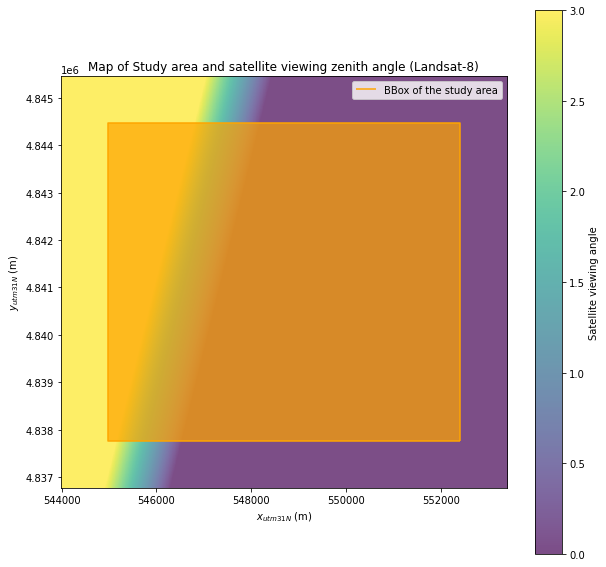

In [8]:
# get bbox of the study area 
bbox=get_points_bbox(path2points,point_file=point_file)

# select ground station 
sta_select=select_sta_grid(path2sta,bbox,buffer_distance=3*sqrt(2)*safran_res) 

# select safran grid points 
safran_select,x_select,y_select=select_safran_grid(path2safran,bbox,buffer_distance=1.5*sqrt(2)*safran_res,
                                                  x_safran=x_safran,y_safran=y_safran) 
fig, ax = plt.subplots (figsize = (10,10))
# DEM
dem=rasterio.open(os.path.join(path2wd,name,'ffid'+str(idfeu),'rs_data','ffid'+str(idfeu)+"_satellite_viewing_angles.tif"))
dem_np=dem.read(1)/100
dem_plot=plt.imshow(dem_np,cmap='viridis',vmin=0,vmax=3,alpha=0.7,)
fig.colorbar(dem_plot,label='Satellite viewing angle')
dem_plot=show((dem_np), ax=ax, transform=dem.transform, cmap='viridis',vmin=0,vmax=3,alpha=0.7,)
dem.close()

bbox.plot(ax = ax, alpha = 0.7, color = "orange")
bbox.boundary.plot(ax = ax, color = "orange",label='BBox of the study area' )
#scrs=bbox.crs
#safran_select.to_crs(scrs).plot(ax=ax,label='Selected Rreanalysis pixel centroids')
#sta_select.to_crs(scrs).plot(ax=ax,label='Selected ground stations')
plt.xlim(bbox.total_bounds[0]-1000,bbox.total_bounds[2]+1000)
plt.ylim(bbox.total_bounds[1]-1000,bbox.total_bounds[3]+1000)

plt.xlabel('$x_{utm31N}$ (m)')
plt.ylabel('$y_{utm31N}$ (m)')
plt.title("Map of Study area and satellite viewing zenith angle (Landsat-8)")
plt.legend()
plt.show()

## Geo data

In the folder 'geo_data' two files must be provided :

| folder | name | format | description | time specs |  Tair disaggregation | LST correction | WDI correction
|:------:|:---------------:|:------:|:------:|:------:|:------:|:------:|:------:|
| geo_data | ffid```idfeu```_gridpoints.shp | ShapeFile | Pixels centroids of rs data in the study area  | - | Yes | Yes | Yes |
| geo_data | ffid```idfeu```_dem.tiff  | GeoTiff | Raster of elevation, slope, aspect | - | Yes | Yes | No |




ffid```idfeu```_gridpoints.shp  contains pixel centroids of remote sensing raster (*e.g.* 30mx30m point grid for Landsat-7/8/9). For each location a unique id named 'ind' must be created. Note that in WGS84-UTM31/32 for instance, coordinates of each point are regularly spaced (30m in each direction) and are intergers.


In [9]:
points=gpd.read_file(path2points,dtype={'ind':int})
points.head()

ind                        geometry
0  23641.0  POINT (546510.000 4837770.000)
1  23640.0  POINT (546480.000 4837770.000)
2  23639.0  POINT (546450.000 4837770.000)
3  23638.0  POINT (546420.000 4837770.000)
4  23637.0  POINT (546390.000 4837770.000)

The raster ffid```idfeu```_dem.tiff provides 3 bands in the following order :
* band 1 : elevation in meters 
* band 2 : slope in degrees
* band 3 : aspect in degrees such North is 0° and south is 180° (as computed by [GDALdem](https://gdal.org/programs/gdaldem.html))

/!\ Note that the bounding box of this raster must contain meteo reanalysis grid points at least.

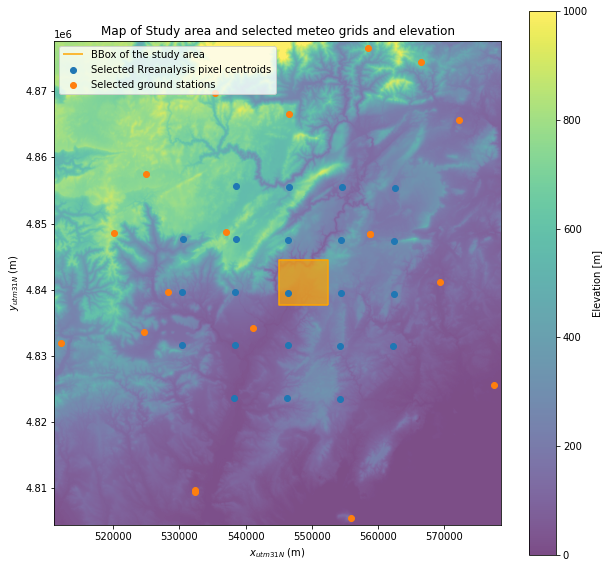

In [10]:
# get bbox of the study area 
bbox=get_points_bbox(path2points,point_file=point_file)

# select ground station 
sta_select=select_sta_grid(path2sta,bbox,buffer_distance=3*sqrt(2)*safran_res) 

# select safran grid points 
safran_select,x_select,y_select=select_safran_grid(path2safran,bbox,buffer_distance=1.5*sqrt(2)*safran_res,
                                                  x_safran=x_safran,y_safran=y_safran) 
fig, ax = plt.subplots (figsize = (10,10))
# DEM
dem=rasterio.open(os.path.join(path2wd,name,'ffid'+str(idfeu),'geo_data','ffid'+str(idfeu)+"_dem.tiff"))
dem_plot=plt.imshow(dem.read(1), cmap='viridis',vmin=0,vmax=1000,alpha=0.7)
fig.colorbar(dem_plot,label='Elevation [m]')
dem_plot=show((dem, 1), ax=ax, cmap='viridis',vmin=0,vmax=1000,alpha=0.7,)
dem.close()

bbox.plot(ax = ax, alpha = 0.7, color = "orange")
bbox.boundary.plot(ax = ax, color = "orange",label='BBox of the study area' )
scrs=bbox.crs
safran_select.to_crs(scrs).plot(ax=ax,label='Selected Rreanalysis pixel centroids')
sta_select.to_crs(scrs).plot(ax=ax,label='Selected ground stations')
plt.xlim(sta_select.to_crs(scrs).total_bounds[0]-1000,sta_select.to_crs(scrs).total_bounds[2]+1000)
plt.ylim(sta_select.to_crs(scrs).total_bounds[1]-1000,sta_select.to_crs(scrs).total_bounds[3]+1000)

plt.xlabel('$x_{utm31N}$ (m)')
plt.ylabel('$y_{utm31N}$ (m)')
plt.title("Map of Study area and selected meteo grids and elevation")
plt.legend()
plt.show()